In [1]:
# Kolejnym etapem projektu jest właświwa weryfikacja skuteczności działania wcześniej wytrenowanych modeli na nowych zbiorach danych.
# Do testowania modelu wykorzystany został plik NetBIOS.csv, który zawiera ruch łagodny oraz ruch atakujący NetBIOS. W porównaniu do
# poprzedniego zbioru danych NetBIOS.csv nie zawiera ataku LDAP.

In [1]:
# Wszystkie wymagane importy

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif


In [2]:
# Wczytanie danych testowych
path = "data/NetBIOS.csv"

dataframe_test = pd.read_csv(path, low_memory=False)

In [3]:
print (sorted(Counter(dataframe_test[" Label"]).items()))

[('BENIGN', 1321), ('NetBIOS', 3454578)]


In [4]:
# Wybieranie cech (ręcznie, na podstawie posiadanej wiedzy) - dokładnie te same cechy, które zostały wcześniej wybrane.
selected_columns = [' Source Port', ' Destination Port', ' Protocol', ' Fwd Packet Length Max', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', 'Fwd Packets/s', ' Bwd Packets/s',' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' Average Packet Size']

# wykorzystanie tylko wcześniej wybranych cech
X_2 = dataframe_test[selected_columns]
Y_2 = dataframe_test[' Label']

In [ ]:
# Kolejnym etapem jest obronienie nowych danych w taki sam sposób jak poprzednich. Należy zastąpić brakujące i nieskończone wartości
# wartościami średnimi dla danej cechy.

In [5]:
# Sprawdzenie, czy są brakujące wartości
# Liczba brakujących wartości w każdej kolumnie
print(X_2.isna().sum())

# Wypełnianie brakujących wartości średnią
X_2 = X_2.fillna(X_2.mean())

# Sprawdzenie, czy są brakujące wartości
# Liczba brakujących wartości w każdej kolumnie
print(X_2.isna().sum())  

# Sprawdzenie obecności wartości inf i -inf w danych
# Liczba wartości inf w każdej kolumnie
print(np.isinf(X_2).sum())  

# Zastąpienie wartości inf lub -inf np. średnią danej kolumny
# Zamiana inf na NaN
X_2 = X_2.replace([np.inf, -np.inf], np.nan)

# Wypełnianie NaN średnią
X_2 = X_2.fillna(X_2.mean())

# Sprawdzenie obecności wartości inf i -inf w danych
# Liczba wartości inf w każdej kolumnie
print(np.isinf(X_2).sum()) 

# Standaryzacja cech
scaler = StandardScaler()
X_2_scaled = scaler.fit_transform(X_2)

# Normalizacja cech do zakresu [0, 1]
scaler = MinMaxScaler()
X_2_normalized = scaler.fit_transform(X_2)

 Source Port              0
 Destination Port         0
 Protocol                 0
 Fwd Packet Length Max    0
Flow Bytes/s              6
 Flow Packets/s           0
 Flow IAT Mean            0
Fwd Packets/s             0
 Bwd Packets/s            0
 SYN Flag Count           0
 RST Flag Count           0
 PSH Flag Count           0
 ACK Flag Count           0
 Average Packet Size      0
dtype: int64
 Source Port              0
 Destination Port         0
 Protocol                 0
 Fwd Packet Length Max    0
Flow Bytes/s              0
 Flow Packets/s           0
 Flow IAT Mean            0
Fwd Packets/s             0
 Bwd Packets/s            0
 SYN Flag Count           0
 RST Flag Count           0
 PSH Flag Count           0
 ACK Flag Count           0
 Average Packet Size      0
dtype: int64
 Source Port                   0
 Destination Port              0
 Protocol                      0
 Fwd Packet Length Max         0
Flow Bytes/s              130560
 Flow Packets/s          

In [6]:
# Działanie na nowych danych testowych
scaler = StandardScaler()

# Normalizacja danych testoweych w ten sam sposób co danych treningowych
X_2_scaled = scaler.fit_transform(X_2)

In [7]:
# Załadowanie wcześniej zapisanego modelu wytrenowanego na danych niezbalansowanych
model_unbalanced = joblib.load('unbalanced_model.pkl')

In [8]:
# Predykcja na nowych danych testowych
Y_2_pred = model_unbalanced.predict(X_2_scaled)  # Jeśli używasz X_2_scaled

# Ocena dokładności modelu
accuracy = accuracy_score(Y_2, Y_2_pred)
print("Accuracy:", accuracy)

# Raport klasyfikacji
print("\nClassification Report:")
# print(classification_report(Y_2, Y_2_pred))

# Raport klasyfikacji z parametrem zero_division
print(classification_report(Y_2, Y_2_pred, zero_division=1))

Accuracy: 0.005047890577820706

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.57      0.98      0.72      1321
        LDAP       0.00      1.00      0.00         0
     NetBIOS       1.00      0.00      0.01   3454578

    accuracy                           0.01   3455899
   macro avg       0.52      0.66      0.24   3455899
weighted avg       1.00      0.01      0.01   3455899



In [ ]:
# Ocena skuteczności modelu bazując na nowym zbiorze danych całkowicie podważyła wcześniejsze wyniki. Obecnie model uzyskał dokładność
# na poziomie 0.005047890577820706 co jest wartością krytyczną.

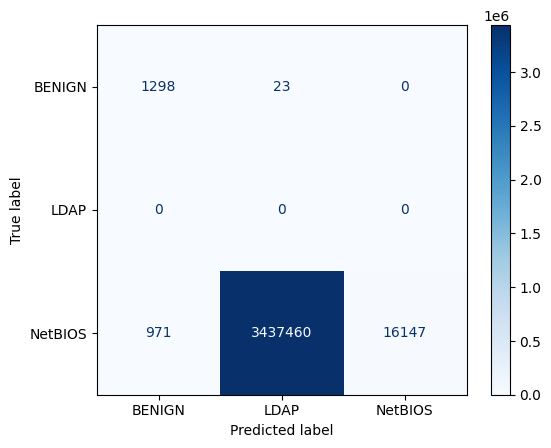

In [9]:
# Obliczenie macierzy pomyłek
cm = confusion_matrix(Y_2, Y_2_pred)

# Wizualizacja macierzy pomyłek
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_unbalanced.classes_)

# Formatowanie wartości w macierzy pomyłek jako liczby całkowite
disp.plot(cmap='Blues', values_format='d')

# Wyświetlenie wykresu
plt.show()


In [ ]:
# Jednakże predykcje modelu wskazują, że poprawnie rozpoznaje on ruch łagodny oraz ruch atakujący. Jego największą wadą jest fakt,
# że nie potrafi określić jaki rodzaj ataku został przeprowadzony (jaki protokół został wykorzystany w ataku DDoS).
# Model niemalże całkowicie mylo atak NetBIOS i klasyfikuje go jako LDAP pomimo, że w zbiorze danych testowych nie znajduje się ani jedna próbka
# danych z label "LDAP" - [('BENIGN', 1321), ('NetBIOS', 3454578)]

In [ ]:
# Następnie sprawdzany jest model, który został wytrenowany na danych zbalansowanych, ale o małej liczebności klas.

In [10]:
# Załadowanie wcześniej zapisanego modelu
model_undersampling = joblib.load('undersampling_model.pkl')

In [11]:
# Predykcja na nowych danych testowych
Y_2_pred = model_undersampling.predict(X_2_scaled)  # Jeśli używasz X_2_scaled

# Ocena dokładności modelu
accuracy = accuracy_score(Y_2, Y_2_pred)
print("Accuracy:", accuracy)

# Raport klasyfikacji
print("\nClassification Report:")
# print(classification_report(Y_2, Y_2_pred))

# Raport klasyfikacji z parametrem zero_division
print(classification_report(Y_2, Y_2_pred, zero_division=1))

Accuracy: 0.5208815419663595

Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.00      1.00      0.00      1321
        LDAP       0.00      1.00      0.00         0
     NetBIOS       1.00      0.52      0.68   3454578

    accuracy                           0.52   3455899
   macro avg       0.33      0.84      0.23   3455899
weighted avg       1.00      0.52      0.68   3455899



In [ ]:
# Bazując na accuracy można stwierdzić, że model trenowany na danych zbalansowanych lepiej klasyfikował próbki niż poprzedni, którego trening
# wykorzystywał dane niezbalansowane.

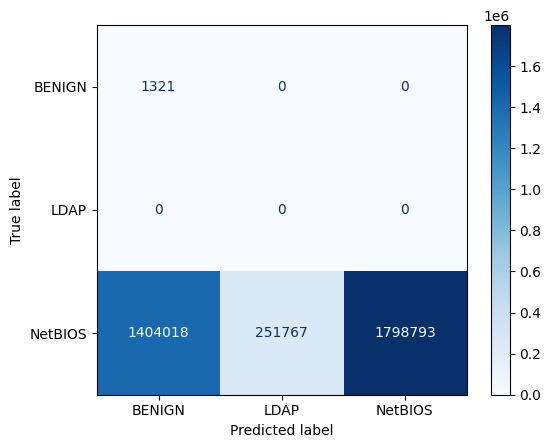

In [12]:
# Obliczenie macierzy pomyłek
cm = confusion_matrix(Y_2, Y_2_pred)

# Wizualizacja macierzy pomyłek
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_undersampling.classes_)

# Formatowanie wartości w macierzy pomyłek jako liczby całkowite
disp.plot(cmap='Blues', values_format='d')

# Wyświetlenie wykresu
plt.show()


In [ ]:
# Jednakże z macieży "confusion matrix" wynika, że predykcje modelu pomimo statystycznie częstszych trafnych decyzji wynikają
# z faktu, że model znacznie częściej klasyfikował atak NetBIOS jako właściwy NetBIOS. Jednakże jego ogólne działanie okazało się
# znacznie gorze niż poprzedniego modelu, ponieważ bardzo czeęsto mylił ruch NetBIOS z ruchem łagodnym, co w przypadku
# ataku DDoS stanowi krytyczny błąd dla bezpieczeństwa systemów i sieci.

# Na tym etapie projektu po mimo, że model unbalanced_model.pkl osiągnął dokładność na poziomie 0.005047890577820706 to zdecydowanie lepiej
# radził sobie z klasyfikacją, czy badany ruch jest atakiem, czy ruchem łagodnym, niż model undersampling_model.pkl, którego dokłądność wynosiła
# 0.5208815419663595.

# Z punktu widzenia praktycznego działania i dbania o bezpieczeństwo można stwierdzić, że model unbalanced_model.pkl lepiej radzi sobie
# z wykrywaniem ataków, jednakże ma bardzo duże problemy z rozróżnianiem klasy ataku. 
# Pomimo tych problemów w ocenie skuteczności pod względem zapewnienia bezpieczeństwa jego wyniki są zdecydowanie lepsze 
# niż modelu undersampling_model.pkl

# Dalsza część projektu zanjduje się w pliku v4_automated_feature_selection.ipynb